In [1]:
import os
import sys
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Reshape, Dropout, Concatenate
from keras.layers import Conv2D, MaxPool2D, Embedding
from keras.models import Model

BASE_DIR = 'C:/Users/username/Documents/chatbot/textcnn'
GLOVE_DIR = BASE_DIR + '/glove.6B/'
TEXT_DATA_DIR = BASE_DIR + '/data/processed_data'
MAX_SEQUENCE_LENGTH = 150 # Maximum number of words in a sentence
MAX_NB_WORDS = 200000 # Vocabulary size
EMBEDDING_DIM = 200 # Dimensions of Glove word vectors 
VALIDATION_SPLIT = 0.20

Using TensorFlow backend.


In [0]:
df = json.loads(requests.get('https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json').text)

In [0]:
''' Getting Training data '''
inscope_train = pd.DataFrame(df['train'],columns=['query','intent'])
oss_train = pd.DataFrame(df['oos_train'],columns=['query','intent'])

''' Getting Validation data '''
inscope_val = pd.DataFrame(df['val'],columns=['query','intent'])
oss_val = pd.DataFrame(df['oos_val'],columns=['query','intent'])

''' Getting Test data '''
# inscope_test = pd.DataFrame(df['test'],columns=['query','intent'])
# test_df = pd.DataFrame(df['test'],columns=['query','intent'])
# oss_test = pd.DataFrame(df['oos_test'],columns=['query','intent'])
test_df = pd.DataFrame(df['oos_test'],columns=['query','intent'])


train_df = pd.concat([inscope_train,oss_train])
val_df = pd.concat([inscope_val,oss_val])
# test_df = pd.concat([inscope_test,oss_test])

In [0]:
train_df = train_df.append(val_df).reset_index(drop=True)

In [5]:
train_df.head()

,query,intent
0,what expression would i use to say i love you ...,translate
1,can you tell me how to say 'i do not speak muc...,translate
2,"what is the equivalent of, 'life is good' in f...",translate
3,"tell me how to say, 'it is a beautiful morning...",translate
4,"if i were mongolian, how would i say that i am...",translate


In [6]:
# texts = np.load(open('data/train_text.npy', 'rb')).tolist()
# labels = np.load(open('data/train_label.npy', 'rb')).tolist()
texts = train_df['query'].to_numpy()
labels = train_df['intent'].to_numpy()

# test_texts = np.load(open('data/test_text.npy', 'rb')).tolist()
# test_labels = np.load(open('data/test_label.npy', 'rb')).tolist()
test_texts = test_df['query'].to_numpy()
test_labels = test_df['intent'].to_numpy()


# Label Encoding: converting text labels into the integers
from sklearn import preprocessing

train_le = preprocessing.LabelEncoder()
train_le.fit(labels)

from sklearn.externals import joblib #Saving label encoder, we will need it later
joblib.dump(train_le, 'C:\\Users\\varun\\Downloads\\label_encoder.pkl') 

labels = train_le.transform(labels)
test_labels = train_le.transform(test_labels)

label_dict = dict(zip(list(train_le.classes_), train_le.transform(list(train_le.classes_))))
print(label_dict)

{'accept_reservations': 0, 'account_blocked': 1, 'alarm': 2, 'application_status': 3, 'apr': 4, 'are_you_a_bot': 5, 'balance': 6, 'bill_balance': 7, 'bill_due': 8, 'book_flight': 9, 'book_hotel': 10, 'calculator': 11, 'calendar': 12, 'calendar_update': 13, 'calories': 14, 'cancel': 15, 'cancel_reservation': 16, 'car_rental': 17, 'card_declined': 18, 'carry_on': 19, 'change_accent': 20, 'change_ai_name': 21, 'change_language': 22, 'change_speed': 23, 'change_user_name': 24, 'change_volume': 25, 'confirm_reservation': 26, 'cook_time': 27, 'credit_limit': 28, 'credit_limit_change': 29, 'credit_score': 30, 'current_location': 31, 'damaged_card': 32, 'date': 33, 'definition': 34, 'direct_deposit': 35, 'directions': 36, 'distance': 37, 'do_you_have_pets': 38, 'exchange_rate': 39, 'expiration_date': 40, 'find_phone': 41, 'flight_status': 42, 'flip_coin': 43, 'food_last': 44, 'freeze_account': 45, 'fun_fact': 46, 'gas': 47, 'gas_type': 48, 'goodbye': 49, 'greeting': 50, 'how_busy': 51, 'how_ol

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [7]:


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

Found 6135 unique tokens.
Shape of data tensor: (18350, 150)
Shape of label tensor: (18350, 151)
Preparing embedding matrix.


In [8]:
print('Indexing word vectors.')

# GLOVE_DIR = 'D:\\nlpproject\\CNN_Intent_Classification-master\\CNN_Intent_Classification-master\\glove.6B'

# from google.colab import files
# uploaded = files.upload()
# file_name = "hello.txt"
# f = uploaded[file_name].decode("utf-8").split("\r\n")
# for i in range(len(f)):
#   f[i] = f[i].split(" ")

embeddings_index = {}
f = open("glove.6B.200d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 360802 word vectors.


In [0]:

num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
filter_sizes = [3,4,5]
num_filters = 200
drop = 0.6

print("Creating Model...")
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = Embedding(input_dim=len(word_index) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH, trainable=False)(inputs)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
preds = Dense(len(label_dict), activation='softmax')(dropout)

# this creates a model that includes inputs and outputs
model = Model(inputs=inputs, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Creating Model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 200)     1227200     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 150, 200, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 148, 1, 200)  120200      reshape_1[0][0]                  
__________________________________________________________________________

In [11]:
history = model.fit(x_train, y_train,
          batch_size=16,
          epochs=50,
          validation_data=(x_val, y_val))

Train on 14680 samples, validate on 3670 samples
Epoch 1/50
14680/14680 [==============================] - 15s 994us/step - loss: 2.3286 - acc: 0.5093 - val_loss: 0.6557 - val_acc: 0.8550
Epoch 2/50
14680/14680 [==============================] - 8s 526us/step - loss: 0.7109 - acc: 0.8178 - val_loss: 0.4097 - val_acc: 0.8946
Epoch 3/50
14680/14680 [==============================] - 8s 525us/step - loss: 0.4601 - acc: 0.8748 - val_loss: 0.3362 - val_acc: 0.9147
Epoch 4/50
14680/14680 [==============================] - 8s 525us/step - loss: 0.3643 - acc: 0.8990 - val_loss: 0.2959 - val_acc: 0.9188
Epoch 5/50
14680/14680 [==============================] - 8s 512us/step - loss: 0.2962 - acc: 0.9159 - val_loss: 0.2945 - val_acc: 0.9199
Epoch 6/50
14680/14680 [==============================] - 8s 514us/step - loss: 0.2647 - acc: 0.9241 - val_loss: 0.2793 - val_acc: 0.9240
Epoch 7/50
14680/14680 [==============================] - 8s 519us/step - loss: 0.2286 - acc: 0.9330 - val_loss: 0.2636 - 

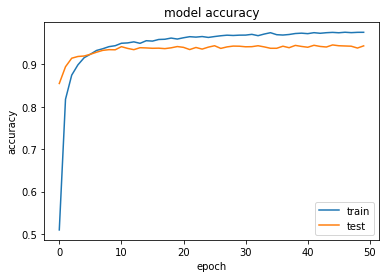

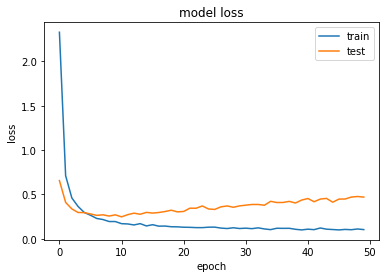

In [12]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
# Processing text to be compatible with model input

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_input = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Get predictions
test_predictions_probas = model.predict(test_input)
test_predictions = test_predictions_probas.argmax(axis=-1)

In [14]:
from sklearn.metrics import classification_report

test_intent_predictions = train_le.inverse_transform(test_predictions)
test_intent_original = train_le.inverse_transform(test_labels)

print('accuracy: ', sum(test_intent_predictions == test_intent_original) / len(test_labels))
print("Precision, Recall and F1-Score:\n\n", classification_report(test_intent_original, test_intent_predictions))

accuracy:  0.38
Precision, Recall and F1-Score:

                            precision    recall  f1-score   support

      accept_reservations       0.00      0.00      0.00         0
          account_blocked       0.00      0.00      0.00         0
       application_status       0.00      0.00      0.00         0
                      apr       0.00      0.00      0.00         0
            are_you_a_bot       0.00      0.00      0.00         0
                  balance       0.00      0.00      0.00         0
             bill_balance       0.00      0.00      0.00         0
                 bill_due       0.00      0.00      0.00         0
              book_flight       0.00      0.00      0.00         0
               book_hotel       0.00      0.00      0.00         0
               calculator       0.00      0.00      0.00         0
                 calendar       0.00      0.00      0.00         0
          calendar_update       0.00      0.00      0.00         0
           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
import csv
from itertools import zip_longest
a = [test_texts, test_intent_original, test_intent_predictions]
data = zip_longest(*a, fillvalue = '')
#print(a)
with open("results_CNN.csv", "w") as results_CNN_file:
    wr = csv.writer(results_CNN_file, delimiter=',')
    wr.writerow(("Query", "Actual Intent", "Predicted Intent"))
    wr.writerows(data)
results_CNN_file.close()